# <div style="text-align:center; color:rgba(37, 40, 80);">11752 Machine Learning</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Master in Intelligent Systems</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Universitat de les Illes Balears</div>

### <div style="text-align:center; color:white;"> Handout #3: **Instance-based learning**</div>

#### **Integrants:** Jason Adel Noboa Rivera, Pedro Marti Pico
#### **Group:** 07





In [41]:
import numpy as np
import cvxpy as cp
from sklearn import svm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import copy

from sklearn.metrics import accuracy_score, f1_score,  precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

group = '07' 

In [42]:
'''FUNCTIONS FOR LINEAR SVM'''
def build_H(X, y): #Function to calculate the H matrix 
    H = []
    for x1, y1 in zip(X,y):
        rows = []
        for x2, y2 in zip(X,y):
            value = (y1 * y2 * np.dot(x1, x2)).item()
            rows.append(value)
        H.append(rows)
    return H

def calculate_w(X,y,lm): #Function to calculate w from landa's values
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] 
    w = [0,0]
    for i in index:
        w += np.multiply(lm[i]*y[i],X[i])
    return w

def calculate_w0(X,y,w,lm): #Function to calculate w0 from landa's values
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6]
    w0 = [0]
    for i in index:
        w0 += y[i] - w @ X[i].T #Formula is yi - w.Txi but we did in this way beacuse the disposition of the samples
    return w0/len(index)
    
def plot_class(c, X, y): #Function to plot class
    m1 = ['k', 'w']
    m2 = ['x', 'x']
    i = np.where(y == c)[0]
    plt.scatter(X[i, 0], X[i, 1], c=m1[c], marker=m2[c], label=f'w{c+1}')

#Create class in order to use in the classificacion map: rediction = model.predict([x])
class modelQPST1:
    def __init__(self, w, w0):
        self.w = w
        self.w0 = w0

    def predict(self, x):
        value = self.w[0]*x[0][0] + self.w[1]*x[0][1] + self.w0[0]
        if value < 0:
            value = [-1]
        else:
            value = [1]
        return value
    
class modelQPST2:
    def __init__(self, w, w0):
        self.w = w
        self.w0 = w0

    def predict(self, x):
        value = self.w[0]*(x[0][0]*x[0][1]) + self.w[1]*((x[0][0])**2 + (x[0][1])**2) + abs(self.w0[0])
        if value < 0:
            value = [-1]
        else:
            value = [1]
        return value
    

'''FUNCTION FOR NON-LINEAR SVM'''
#We need this function here in order to use it in the classification map 
def calculate_phi(X):
    n, m = np.array(X).shape
    X_phi = []
    for x in X:
        x_phi = []
        x_phi.append(x[0]*x[1])
        x_phi.append((x[0]**2)+(x[1]**2))
        X_phi.append(x_phi)

    X_phi = np.array(X_phi)
    X_phi = X_phi.reshape(n,m)
    return X_phi
    

In [43]:
'''PLOT FUNCTIONS'''
#Function used for data visualization
def plot_data(X,y):
    y = np.squeeze(y)

    #Plot the samples
    X1 = X[y == 1.0]  #Points of class w1

    X2 = X[y == -1.0]  #Points of class w2
    if len(X2) == 0:
        X2 = X[y == 0.0]

    plt.scatter(X1[:, 0], X1[:, 1], color='green', marker='x', label='W1')  #Plot points of class w1
    plt.scatter(X2[:, 0], X2[:, 1], color='red', marker='x', label='W2')  #Plot points of class w2

    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    #plt.show()

#Create this function in order to plot the linear decision function  
def plot_l_decision_func(X, y, sv, w, w0, plt, plot_title:str = ''):
    #plt.figure(figsize=(6, 6))

        # Set the limits of the axes for better visualization
    x1lim = [X[:, 0].min(), X[:, 0].max()]
    x2lim = [X[:, 1].min(), X[:, 1].max()]

    plt.xlim([x1lim[0]-0.2, x1lim[1]+0.2])
    plt.ylim([x2lim[0]-0.2, x2lim[1]+0.2])

    #Add the circles in supported vector machines
    for loc in sv: #Locate the support vectors stored in sv
        px, py = loc
        circle = Circle((px,py), (x1lim[1]-x1lim[0])/50, fill=False)
        plt.gca().add_patch(circle)


    #Add the decision curve
            #Add the decision curve
    #Create x values
    num = 500
    xx = np.linspace(x1lim[0]-0.2, x1lim[1]+0.2, num)
    yy = np.linspace(x2lim[0]-0.2, x2lim[1]+0.2, num)
    YY, XX = np.meshgrid(yy, xx)
    Z = np.zeros((num * num,1))
    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] = w[0]*x1 + w[1]*x2 + w0[0]
            k += 1
    ax = plt.gca()
    # specify colors for each level
    ax.contour(XX,YY,Z.reshape(XX.shape),colors=['k', 'lightblue', 'k'],levels=[-1, 0, 1],alpha=0.5,linestyles=['--', '-', '--'])

        
    plt.title(plot_title, fontsize = 6 )

    plot_data(X, y)
    #plt.legend()
    #plt.show()

'''CLASSIFICATION MAP'''
def plot_classification_map(X, y, model, plt, precomputed = False):
    #Code used from teacher in previous handout
    x1lim = [X[:, 0].min(), X[:, 0].max()]
    x2lim = [X[:, 1].min(), X[:, 1].max()]

    npts = 300 #The higher the value, the better the classification map display, but the slower it will be. [100 is faster - 300 is nicer ]
    x1s = np.linspace(x1lim[0]-1, x1lim[1]+1, npts)
    x2s = np.linspace(x2lim[0]-1, x2lim[1]+1, npts)

    model = model

    m = np.zeros((npts, npts))
    for k1, x1 in enumerate(x1s):
        for k2, x2 in enumerate(x2s):
            x = np.array([x1, x2])
            if precomputed: #Use this when kernel = 'precomputed'
                x = calculate_phi([x])
                X_trans = calculate_phi(X)
                x = np.dot(x[0], X_trans.T)
            prediction = model.predict([x])
            m[k1, k2] = prediction[0]

    plt.xlim([x1lim[0]-0.2, x1lim[1]+0.2])
    plt.ylim([x2lim[0]-0.2, x2lim[1]+0.2])
    plt.imshow(m.T, cmap='RdYlGn', origin='lower', extent=(x1lim[0]-1, x1lim[1]+1, x2lim[0]-1, x2lim[1]+1))
    for c in range(2):
        plot_class(c, X, y)
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    #plt.show()

##### T1. **Given dataset dsgg1.txt:**

a)	Solve for the SVM analytically using the Karush-Kuhn-Tucker conditions and the Wolfe dual representation making use of the quadratic programming solver and:

•	find and report the support vectors (NOTE: due to round-off errors, it is likely none of the $λ_i$ are exactly 0, but close, e.g. $10^{-6}$), and

•	calculate and report the resulting decision function $g(x)= w^T x+w_0.$

In [44]:
'''
1. commented source code
2. support vectors
3. decision function 
'''
#Import data
task = 1
data = np.loadtxt('ds'+group+str(task)+'.txt')
X = data[:,0:2]
oy = data[:,2:3] #CLass labels are 1 for w1 and 0 for w2

y = copy.deepcopy(oy)

y = np.where(y == 0, -1, 1) #Change -1 instead 0 to execute the solver otherwise solver didn't work

#Code from slides
N = X.shape[0]
P = build_H(X,y)
G = -np.identity(N)
h = np.zeros((N,1))
A = y.reshape((1,N))
b = 0.0
z = cp.Variable((N,1))
P = P + (1e-8) * np.identity(N) # for numerical stability
prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(z,P) - cp.sum(z)), 
                  [G @ z <= h, A @ z == b])
prob.solve(solver = cp.ECOS)
#print(prob.status)
lm = z.value  #This are landas

'''Support Vectors'''
index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] #Index of values different of 0
sv_sqp = X[index] #Obtain the support vectors
print(f"Support Vectors:\n {sv_sqp}")

'''Decision function'''
#Calculate w and w0 from landa's values
w_sqp = calculate_w(X,y,lm)
w0_sqp = calculate_w0(X,y,w_sqp,lm)

#print(f"w = {(w.round(5))}")
#print(f"w0 = {(w0.round(5))}")
print(f'\ng(x): {w_sqp[0].round(5)}x1 + {w_sqp[1].round(5)}x2 + {w0_sqp[0].round(5)} = 0')


Support Vectors:
 [[-0.82782933 -0.56098003]
 [-3.89957879  2.18935727]
 [ 0.2668493   1.38880936]]

g(x): 0.61119x1 + 0.68261x2 + -0.11111 = 0


b)	Generate the following plots:

•	a first plot with the training samples, highlighting the support vectors and plotting the 2D decision curve

•	a second plot with the classification map, i.e. evaluate the decision function for a 'regular' subset (grid) of points of the feature space
Use different markers and/or colours for each class.


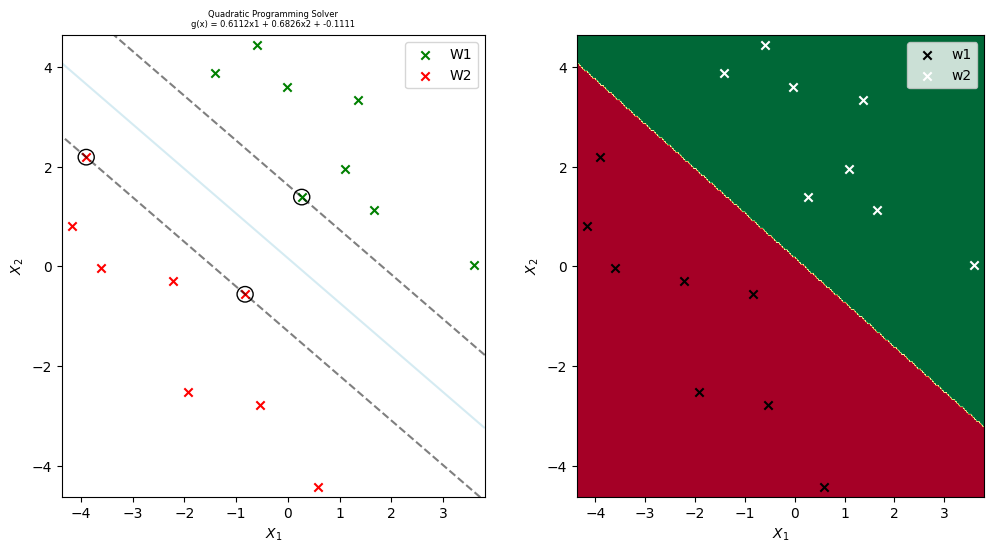

In [45]:
'''
1. commented source code
2. plot with samples and contour corresponding to the decision function
3. classification map
'''
model = modelQPST1(w_sqp,w0_sqp) #Calculate our QPS model for T1
title = f'Quadratic Programming Solver\ng(x) = {w_sqp[0].round(4)}x1 + {w_sqp[1].round(4)}x2 + {w0_sqp[0].round(4)}'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_l_decision_func(X,y,sv_sqp,w_sqp,w0_sqp,plt,title)
plt.subplot(1, 2, 2)
plot_classification_map(X,oy,model,plt)

c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

Support Vectors:
 [[-0.82782933 -0.56098003]
 [-3.89957879  2.18935727]
 [ 0.2668493   1.38880936]]

g(x) = 0.61098x1 + 0.68238x2 + -0.11119


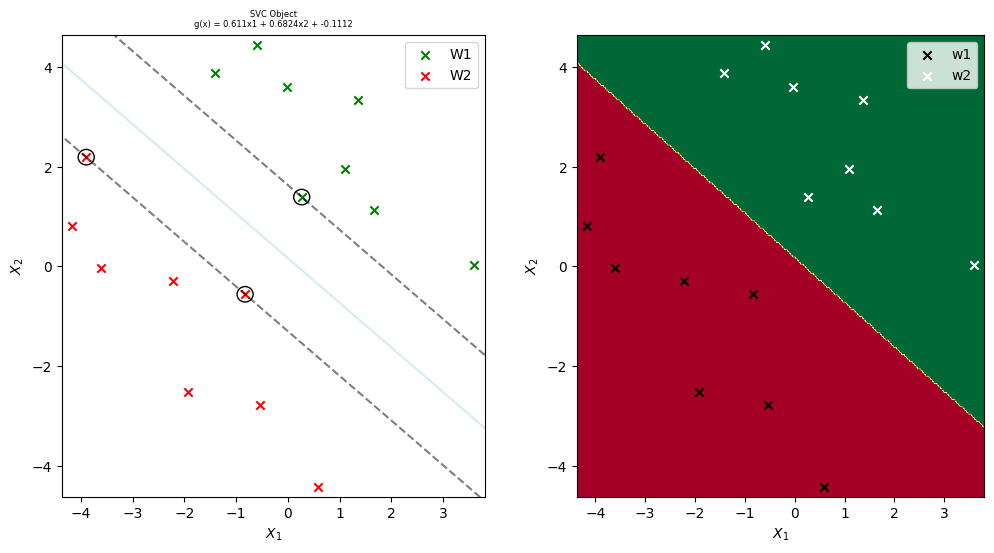

In [46]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''
y = np.squeeze(y)

#Configurate the model
svm_linear = svm.SVC(C = 1e16, kernel = 'linear') 
svm_linear.fit(X, y)

#Obtain the respective support vectors and weights
sv_l = svm_linear.support_vectors_
w_l = svm_linear.coef_.flatten()
w0_l = svm_linear.intercept_

print(f"Support Vectors:\n {sv_l}")
print(f'\ng(x) = {w_l[0].round(5)}x1 + {w_l[1].round(5)}x2 + {w0_l[0].round(5)}')

title = f'SVC Object\ng(x) = {w_l[0].round(4)}x1 + {w_l[1].round(4)}x2 + {w0_l[0].round(4)}'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_l_decision_func(X,y,sv_l,w_l,w0_l,plt,title)
plt.subplot(1, 2, 2)
plot_classification_map(X,oy,svm_linear,plt)



In [47]:
#Comparation between both models
print("                                 MODEL COMPARATION                                ")
print("----------------------------------------------------------------------------------")
print("                SQP Model               |                SVC Model                ")
print("                                 Support Vectors                                  ")
print(f"            {sv_sqp[0].round(3)}             |               {sv_l[0].round(3)}         ")
print(f"            {sv_sqp[1].round(3)}             |               {sv_l[1].round(3)}         ")
print(f"             {sv_sqp[2].round(3)}              |                {sv_l[2].round(3)}      ")
print("                               Decision function                 ")
print(f'g(x) = {w_sqp[0].round(5)}x1 + {w_sqp[1].round(5)}x2 + {w0_sqp[0].round(5)} | g(x) = {w_l[0].round(5)}x1 + {w_l[1].round(5)}x2 + {w0_l[0].round(5)}')

                                 MODEL COMPARATION                                
----------------------------------------------------------------------------------
                SQP Model               |                SVC Model                
                                 Support Vectors                                  
            [-0.828 -0.561]             |               [-0.828 -0.561]         
            [-3.9    2.189]             |               [-3.9    2.189]         
             [0.267 1.389]              |                [0.267 1.389]      
                               Decision function                 
g(x) = 0.61119x1 + 0.68261x2 + -0.11111 | g(x) = 0.61098x1 + 0.68238x2 + -0.11119


##### T2. **Given dataset dsgg2.txt:**


In [48]:
'''FUNCTIONS FOR NON-LINEAR SVM'''
def build_H_wpk(X, y, gamma, r, q):
    H = []
    for x1, y1 in zip(X,y):
        rows = []
        for x2, y2 in zip(X,y):
            value = (y1 * y2 * ((gamma*(np.dot(x1, x2)))+r)**q).item()
            rows.append(value)
        H.append(rows)
    return H

def calculate_w_wpk(X_trans,y,lm):
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] #Index of values different of 0
    w = [0,0]
    for i in index:
        w += np.multiply(lm[i]*y[i],X_trans[i])

    return w

def calculate_w0_wpk(X_trans,y,w,lm, index = []):
    index = index
    if len(index) == 0:
        index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6]
    w0 = [0]
    for i in index:
        w0 += y[i] - w @ X_trans[i]
    return w0/len(index)

'''PLOT FUNCTION'''
#Create this function in order to plot the non-linear decision function in the original space
#The transformed space can be plotted with the plot_l_decision_func function
def plot_non_l_decision_func(X_s, y_s, sv_s, w_s, w0_s, plt, plot_title_s:str = 'Plot'):
    #plt.figure(figsize=(6, 6))

        # Set the limits of the axes for better visualization
    x1lim = [X_s[:, 0].min(), X_s[:, 0].max()]
    x2lim = [X_s[:, 1].min(), X_s[:, 1].max()]

    plt.xlim([x1lim[0]-0.2, x1lim[1]+0.2])
    plt.ylim([x2lim[0]-0.2, x2lim[1]+0.2])

        #Add the decision curve
    #Create x values
    num = 500
    xx = np.linspace(x1lim[0]-0.2, x1lim[1]+0.2, num)
    yy = np.linspace(x2lim[0]-0.2, x2lim[1]+0.2, num)
    YY, XX = np.meshgrid(yy, xx)
    Z = np.zeros((num * num,1))
    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] = w_s[0]*(x1*x2) + w_s[1]*((x1)**2 + (x2)**2) + abs(w0_s[0])
            k += 1
    ax = plt.gca()
    # specify colors for each level
    ax.contour(XX,YY,Z.reshape(XX.shape),colors=['k', 'lightblue', 'k'],levels=[-1, 0, 1],alpha=0.5,linestyles=['--', '-', '--'])

        #Add the circles in supported vector machines
    #Locate the support vectors stored in sv
    for loc in sv_s: 
        px, py = loc
        circle = Circle((px,py), (x1lim[1]-x1lim[0])/50, fill=False)
        plt.gca().add_patch(circle)
        
    plt.title(plot_title_s, fontsize = 6 )

    plot_data(X_s, y_s)


a)Mapping the training samples $x=(x_1,x_2)$ onto an alternative 2-dimensional space using $Φ(x)=(x_1 x_2,{x_1}^2+{x_2}^2)$, solve for the SVM analytically using the quadratic programming solver and

  •	find and report the support vectors in the original space, and

  •	calculate and report the resulting decision function both in the transformed space          $g_1(x')=w^T x'+w_0 [x'=Φ(x)]$ and in the original space $g_2 (x)=w^T Φ(x)+w_0$.

In [49]:
'''
1. commented source code
2. support vectors
3. decision functions
'''
#Import data
task = 2
data = np.loadtxt('ds'+group+str(task)+'.txt')
X_2 = data[:,0:2]
oy_2 = data[:,2:3]

y_2 = copy.deepcopy(oy_2)

# Convert the labels to -1 and +1
y_2 = np.where(y_2 == 0, -1, 1)

# Code from slides
N = X_2.shape[0]
P = build_H_wpk(X_2, y_2, gamma=1, r=1, q=2)
A = y_2.reshape((1,N))
G = np.identity(N)
C = 1
lb = np.zeros((N,1))
ub = C * np.ones((N,1))
z = cp.Variable((N,1))
P = P + (1e-6) * np.identity(N)
prob = cp.Problem(
 cp.Minimize(0.5 * cp.quad_form(z, P)
 - cp.sum(z)),
 [G @ z >= lb, G @ z <= ub, A @ z == 0]
)
prob.solve()
lm_2 = z.value 

'''Support Vectors'''
index_2 = [i for i, lamb in enumerate(lm_2) if lamb[0] > 1e-6]
sv_2 = X_2[index_2]
print(f"Support Vectors:\n {sv_2}")


'''Decision function'''
#Calculate w and w0 from landa's values
X_trans2 = calculate_phi(X_2)
sv_trans2 = X_trans2[index_2] 

w_2 = calculate_w_wpk(X_trans2,y_2,lm_2)
#print(f"w = {(w_2.round(3)).T}")

w0_2 = calculate_w0_wpk(X_trans2,y_2,w_2,lm_2)
#print(f"w0 = {(w0_2.round(3))}")

#TRANSFORMED SPACE
print(f'\nTransformed Space\ng1(x): {w_2[0].round(3)}x1 + {w_2[1].round(3)}x2 + {w0_2[0].round(3)} = 0')

#ORIGINAL SPACE
#print(f'\ng(x) =  ±√ -x^2 + {abs(w0_2[0]/w_2[1]).round(3)}')
print(f'Original Space\ng2(x): {w_2[0].round(3)}(x1x2) + {w_2[1].round(3)}(x1^2 + x2^2) + {w0_2[0].round(3)}')


Support Vectors:
 [[ 0.02276649 -0.56790611]
 [ 0.48308517  0.17996887]
 [ 0.14941257 -0.43752784]
 [ 0.92795713  0.10339909]
 [ 0.88254284 -0.47637973]
 [-0.45328924 -0.17441015]
 [-0.76168941 -0.62814279]
 [ 0.43134487 -0.1708668 ]
 [-0.09083842 -0.45647188]
 [-0.95964905 -0.00979587]
 [-0.52299909  0.13872775]
 [-0.36316507 -0.84385895]
 [-0.93896523  0.40153646]
 [ 0.37367468 -0.33770083]
 [-0.02430107  0.97567027]
 [ 0.38492022  0.9670443 ]
 [-0.60006218  0.08304767]
 [ 0.4093559  -0.86721216]]

Transformed Space
g1(x): -0.054x1 + -4.978x2 + 3.042 = 0
Original Space
g2(x): -0.054(x1x2) + -4.978(x1^2 + x2^2) + 3.042


b)	Generate the following plots:

•	a first plot with the training samples in the transformed space, highlighting the support vectors and plotting the 2D decision curve;

•	a second plot with the training samples in the original space, highlighting the support vectors and plotting the 2D decision curve; and

•	a third plot with the classification map in the original space, i.e. evaluate the decision function for a ’regular’ subset (grid) of points.


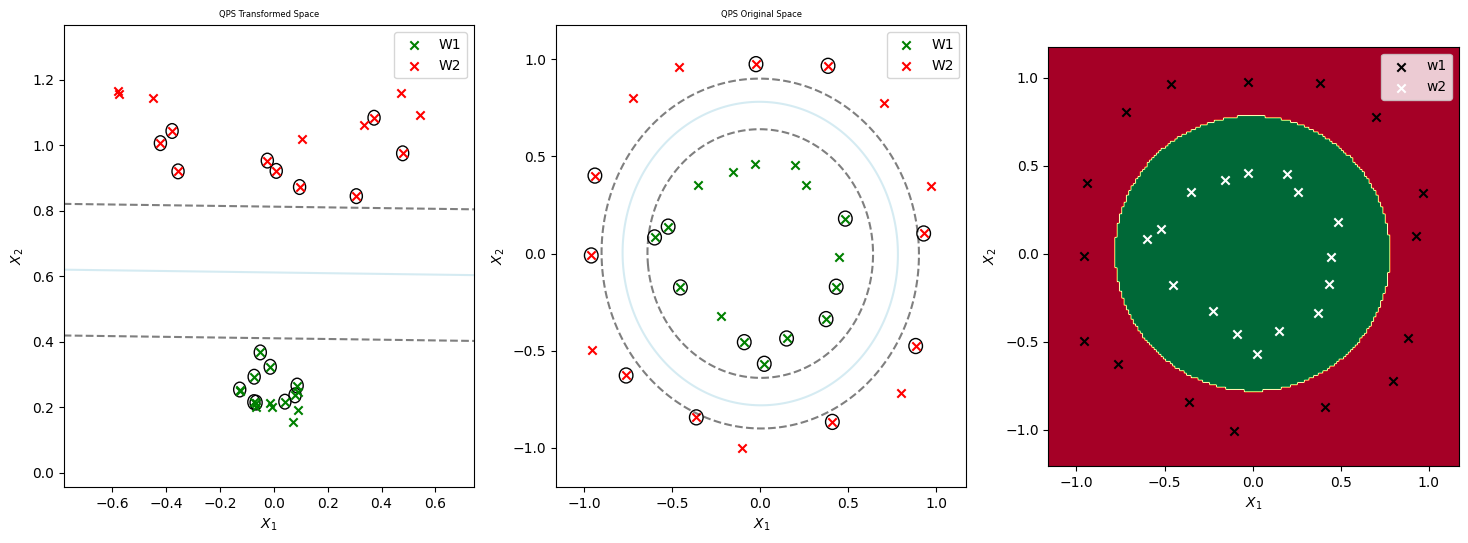

In [50]:
'''
Use different markers and/or colours for each class.
1. commented source code
2. plots with samples and contour corresponding to the decision function
3. classification map
'''
plt.figure(figsize=(18, 6))
#PLOT TRANSFORMED SPACE
plt.subplot(1, 3, 1) 
plot_l_decision_func(X_trans2,y_2,sv_trans2,w_2,w0_2, plt,'QPS Transformed Space')

#PLOT ORIGINAL SPACE
plt.subplot(1, 3, 2) 
plot_non_l_decision_func(X_2,y_2,sv_2,w_2,w0_2,plt,'QPS Original Space')

#PLOT CLASSIFICATION MAP
plt.subplot(1, 3, 3) 
model_2 = modelQPST2(w_2,w0_2)
plot_classification_map(X_2,oy_2,model_2,plt)




c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

In [51]:
def create_lambda(index, size, model):

    # Obtain (y_i * λ_i)
    weights = model.dual_coef_

    # Obtain class labels
    class_labels = y_2[index].flatten()

    # Calculate  λs
    lms = (weights / class_labels)[0]

    # Create an a empty array
    array = np.zeros(size)

    # Asign values given by support index
    for i, valor in zip(index, lms):
        array[i] = valor

    #We did this for simulate the shape of lambdas that obtain from QPS
    array = [[element] for element in array]

    return array

Original Support Vectors from scikit-learn SVC with PRECOMPUTED kernel: 
[[-0.36316507 -0.84385895]
 [ 0.4093559  -0.86721216]
 [-0.60006218  0.08304767]]

Transformed Space
g1(x): -0.44x1 + -3.864x2 + 2.396 = 0
Original Space
g2(x): -0.44(x1x2) + -3.864(x1^2 + x2^2) + 2.396


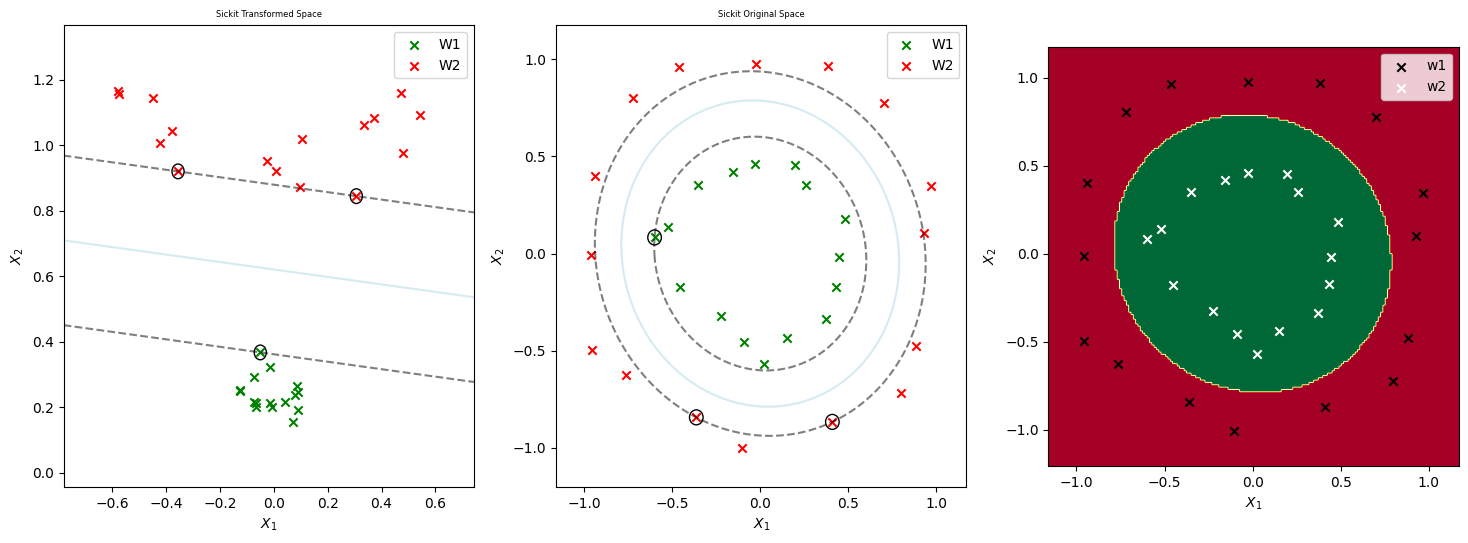

In [52]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''
# Fit the SVC model with precomputed kernel
svm_precomputed = svm.SVC(kernel='precomputed',C=1e16)

#Obtain the Gram Matrix
#gram_train = np.dot(X_trans2, X_trans2.T)
n, m = X_trans2.shape
gram_train = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        for k in range(m):
            gram_train[i][j] += X_trans2[i][k] * X_trans2[j][k]

#Train the model
svm_precomputed.fit(gram_train, y_2.flatten())

index_sv_precomputed = svm_precomputed.support_
sv_p = X_2[index_sv_precomputed]
sv_p_trans = X_trans2[index_sv_precomputed]
print(f'Original Support Vectors from scikit-learn SVC with PRECOMPUTED kernel: \n{sv_p}')

'''Calculate the decision curve'''
lm_p = create_lambda(index_sv_precomputed,len(X_2),svm_precomputed)
w_p = calculate_w_wpk(X_trans2,y_2,lm_p)

w0_p = calculate_w0_wpk(X_trans2,y_2,w_p,lm_p)

#TRANSFORMED SPACE
print(f'\nTransformed Space\ng1(x): {w_p[0].round(3)}x1 + {w_p[1].round(3)}x2 + {w0_p[0].round(3)} = 0')

#ORIGINAL SPACE
print(f'Original Space\ng2(x): {w_p[0].round(3)}(x1x2) + {w_p[1].round(3)}(x1^2 + x2^2) + {w0_p[0].round(3)}')


plt.figure(figsize=(18, 6))
#PLOT TRANSFORMED SPACE
plt.subplot(1, 3, 1) 
plot_l_decision_func(X_trans2,y_2,sv_p_trans,w_p,w0_p,plt,'Sickit Transformed Space')

#PLOT ORIGINAL SPACE
plt.subplot(1, 3, 2) 
plot_non_l_decision_func(X_2,y_2,sv_p,w_p,w0_p,plt,'Sickit Original Space')

#PLOT CLASSIFICATION MAP
plt.subplot(1, 3, 3) 
plot_classification_map(X_2,oy_2,svm_precomputed,plt,precomputed=True)


d) Also by means of the scikit-learn SVC object, repeat point c) for the 'rbf' kernel. Additionally, draw the corresponding RBF network (slide 42 of the SVM lecture notes, replacing $K(x_i,x)$, $λ_i$ and $y_i$ by your values).

Original Support Vectors from scikit-learn SVC with RBF kernel: 
[[ 0.92795713  0.10339909]
 [-0.95964905 -0.00979587]
 [-0.36316507 -0.84385895]
 [-0.93896523  0.40153646]
 [-0.02430107  0.97567027]
 [ 0.4093559  -0.86721216]
 [ 0.02276649 -0.56790611]
 [ 0.48308517  0.17996887]
 [-0.60006218  0.08304767]]


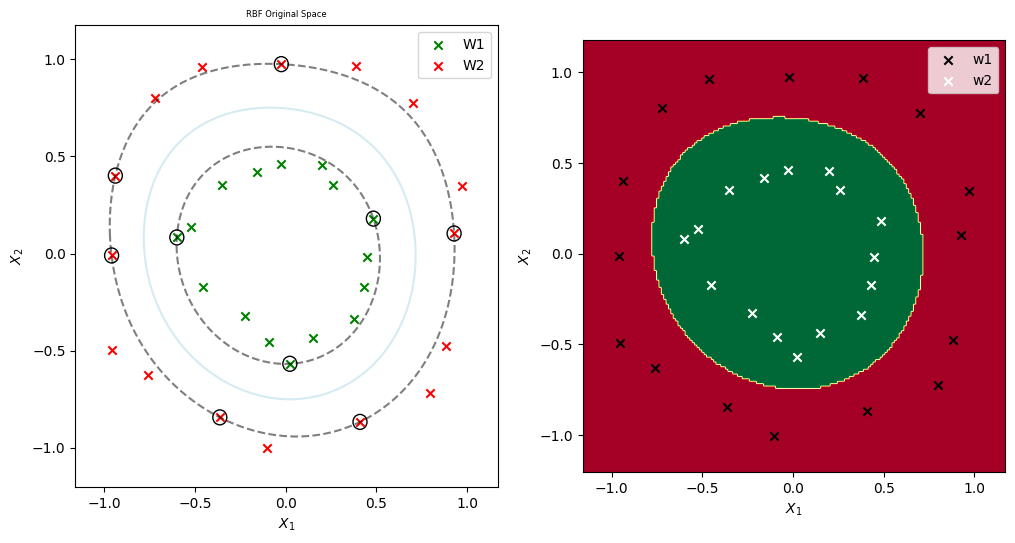

In [53]:
'''
1. commented source code
2. support vectors
3. plot with samples and contour corresponding to the decision function
4. classification map
5. RBF network X y
'''
# Fit the SVC model with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1e16, gamma = 1.0)
svm_rbf.fit(X_2, oy_2.flatten())

# Extract support vectors
index_sv_rbf = svm_rbf.support_
sv_rbf = X_2[index_sv_rbf]
sv_rbf_trans = X_trans2[index_sv_rbf]
print(f'Original Support Vectors from scikit-learn SVC with RBF kernel: \n{sv_rbf}')

#PLOT IN THE ORIGINAL SPACE
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

    # Set the limits of the axes for better visualization
x1lim = [X_2[:, 0].min(), X_2[:, 0].max()]
x2lim = [X_2[:, 1].min(), X_2[:, 1].max()]

plt.xlim([x1lim[0]-0.2, x1lim[1]+0.2])
plt.ylim([x2lim[0]-0.2, x2lim[1]+0.2])

    #Add the decision curve
#Create x values
num = 500
xx = np.linspace(x1lim[0]-0.2, x1lim[1]+0.2, num)
yy = np.linspace(x2lim[0]-0.2, x2lim[1]+0.2, num)
YY, XX = np.meshgrid(yy, xx)
Z = svm_rbf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)
ax = plt.gca()
# specify colors for each level
ax.contour(XX,YY,Z.reshape(XX.shape),colors=['k', 'lightblue', 'k'],levels=[-1, 0, 1],alpha=0.5,linestyles=['--', '-', '--'])

    #Add the circles in supported vector machines
#Locate the support vectors stored in sv
for loc in sv_rbf: 
    px, py = loc
    circle = Circle((px,py), (x1lim[1]-x1lim[0])/50, fill=False)
    plt.gca().add_patch(circle)
    
plt.title('RBF Original Space', fontsize = 6 )

plot_data(X_2, y_2)


#PLOT CLASSIFICATION MAP
plt.subplot(1,2,2)
plot_classification_map(X_2,oy_2,svm_rbf,plt)

In [54]:

weights = svm_rbf.dual_coef_
#Power point
print("RBF Network:")
for i, sv in enumerate(sv_rbf):
    print(f"K: {sv}, λ_i*y_i: {weights[0][i]}")







RBF Network:
K: [0.92795713 0.10339909], λ_i*y_i: -2.1823740543330468
K: [-0.95964905 -0.00979587], λ_i*y_i: -3.9776672910831268
K: [-0.36316507 -0.84385895], λ_i*y_i: -3.378652337651872
K: [-0.93896523  0.40153646], λ_i*y_i: -0.8539461519861089
K: [-0.02430107  0.97567027], λ_i*y_i: -1.3165237676335622
K: [ 0.4093559  -0.86721216], λ_i*y_i: -2.4150042863809382
K: [ 0.02276649 -0.56790611], λ_i*y_i: 5.408549499879451
K: [0.48308517 0.17996887], λ_i*y_i: 2.6937208517186786
K: [-0.60006218  0.08304767], λ_i*y_i: 6.021897537470526


In [56]:

#Comparation between models
print("                                                                    MODEL COMPARATION T2                                                                 ")
print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
print("                     SQP Model                    |                  Precomputed Model               |                       RBF Model                   ")
print("                                                                      Support Vectors                                                                    ")
print(f"                  {sv_2[0].round(3)}                   |                  {sv_p[0].round(3)}                 |                     {sv_rbf[0].round(3)}        ")
print(f"                 {sv_2[1].round(3)}                  |                  {sv_p[1].round(3)}                 |                     {sv_rbf[1].round(3)}        ")
print(f"                  {sv_2[2].round(3)}                   |                  {sv_p[2].round(3)}                 |                    {sv_rbf[2].round(3)}        ")
print(f"                  {sv_2[3].round(3)}                   |                                                  |                    {sv_rbf[3].round(3)}        ")
print(f"                 {sv_2[4].round(3)}                  |                                                  |                    {sv_rbf[4].round(3)}        ")
print(f"                         .                        |                                                  |                    {sv_rbf[5].round(3)}        ")
print(f"                         .                        |                                                  |                    {sv_rbf[6].round(3)}        ")
print(f"                         .                        |                                                  |                     {sv_rbf[7].round(3)}        ")
print(f"                 {sv_2[-1].round(3)}                  |                                                  |                    {sv_rbf[8].round(3)}        ")
print("                                                          Decision function for Transformed Space                                           ")
print(f'     g1(x) = {w_2[0].round(4)}x1 + {w_2[1].round(4)}x2 + {w0_2[0].round(4)}       |      g1(x) = {w_p[0].round(4)}x1 + {w_p[1].round(4)}x2 + {w0_p[0].round(4)}      |      ')
print("                                                           Decision function for Original Space                                             ")
print(f'g2(x): {w_2[0].round(3)}(x1x2) + {w_2[1].round(3)}(x1^2 + x2^2) + {w0_2[0].round(3)}  | g2(x): {w_p[0].round(3)}(x1x2) + {w_p[1].round(3)}(x1^2 + x2^2) + {w0_p[0].round(3)} | ')

                                                                    MODEL COMPARATION T2                                                                 
---------------------------------------------------------------------------------------------------------------------------------------------------------
                     SQP Model                    |                  Precomputed Model               |                       RBF Model                   
                                                                      Support Vectors                                                                    
                  [ 0.023 -0.568]                   |                  [-0.363 -0.844]                 |                     [0.928 0.103]        
                 [0.483 0.18 ]                  |                  [ 0.409 -0.867]                 |                     [-0.96 -0.01]        
                  [ 0.149 -0.438]                   |                  [-0.6    0.083]        

##### T3. **T3.	Given dataset dsgg3tr.txt/dsgg3te.txt**, find a suitable k-Nearest Neighbour (k-NN) classifier to adequately address the involved task.



In [ ]:
'''CROSS VLAIDATION FUNCTION'''
def calculateModel_crossValidation(x, y, model):
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
    accuracy = []
    precision = []
    recall = []
    f1_s = []
    
    for trainIndex, testIndex in rskf.split(x,y):
        x_Train, x_Test = x[trainIndex], x[testIndex]
        y_Train, y_Test = y[trainIndex], y[testIndex]
        # Entrenamos el modelo para cada clase
        trainModel = model.fit(x_Train, y_Train) #Usar crossvalidation

        # Make predictions based on the class with higher posterior probability
        predictions = trainModel.predict(x_Test)

        # Evaluate the performance
        accuracy.append(accuracy_score(y_Test, predictions))
        precision.append(precision_score(y_Test, predictions))
        recall.append(recall_score(y_Test, predictions))
        f1_s.append(f1_score(y_Test, predictions))

    accuracy = np.mean(accuracy)
    precision = np.mean(precision)
    recall = np.mean(recall)
    f1_s = np.mean(f1_s)
    return accuracy, precision, recall, f1_s

a) Define the design strategy: combinations of hyper-parameters considered (number of neighbours and distance function), tuning approach (folds and repetitions).

b)	Using the training dataset, find the best performing classifier according to the design strategy and employing the accuracy as performance metric for the cross-validation process.

For k = 1, metric = euclidean and weight = uniform the total Accuracy is 0.915 


For k = 1, metric = manhattan and weight = uniform the total Accuracy is 0.926 
For k = 1, metric = chebyshev and weight = uniform the total Accuracy is 0.914 
For k = 1, metric = euclidean and weight = distance the total Accuracy is 0.915 
For k = 1, metric = manhattan and weight = distance the total Accuracy is 0.926 
For k = 1, metric = chebyshev and weight = distance the total Accuracy is 0.914 
For k = 5, metric = euclidean and weight = uniform the total Accuracy is 0.956 
For k = 5, metric = manhattan and weight = uniform the total Accuracy is 0.954 
For k = 5, metric = chebyshev and weight = uniform the total Accuracy is 0.949 
For k = 5, metric = euclidean and weight = distance the total Accuracy is 0.957 
For k = 5, metric = manhattan and weight = distance the total Accuracy is 0.953 
For k = 5, metric = chebyshev and weight = distance the total Accuracy is 0.953 
For k = 10, metric = euclidean and weight = uniform the total Accuracy is 0.938 
For k = 10, metric = manhattan an

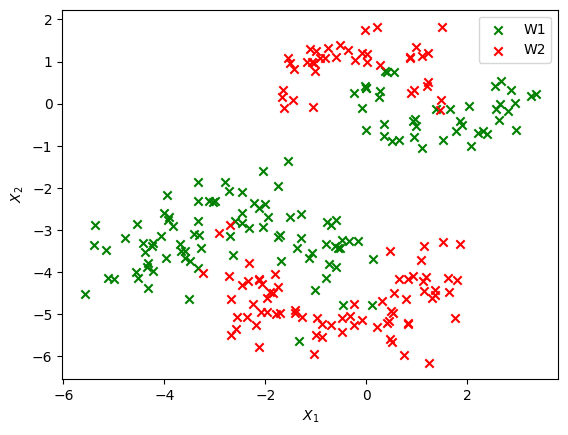

In [ ]:
'''
1. commented source code (for a & b above)
2. resulting configuration
'''
#Import data
task = 3
data_train = np.loadtxt('ds'+group+str(task)+'tr.txt')
data_test = np.loadtxt('ds'+group+str(task)+'te.txt')

X_train = data_train[:,0:2]
y_train = data_train[:,2:3].flatten() #CLass labels are 1 for w1 and 0 for w2


X_test = data_test[:,0:2]
y_test = data_test[:,2:3].flatten() #CLass labels are 1 for w1 and 0 for w2

#Plot data in order to visualice the class distribution
plot_data(X_train,y_train)

#Create a range of parameters
ks = [1,5,10]
metrics = ['euclidean','manhattan','chebyshev']
weights = ['uniform','distance']

#Evaluate the model for all different configurations of parameters in order to obtain the best performance
for k in ks:
    for weight in weights:
        for metric in metrics:
            modelkNN = KNeighborsClassifier(n_neighbors=k, weights=weight, metric =metric)
            accuracy_e, precision_e, recall_e, f1_s = calculateModel_crossValidation(X_train, y_train, modelkNN)
            print(f'For k = {k}, metric = {metric} and weight = {weight} the total Accuracy is {accuracy_e.round(3)} ')


c)	Plot the training samples on top of the classification map, i.e. evaluate the decision function for a ’regular’ subset (grid) of points of the feature space (use different markers and/or colours for each class).

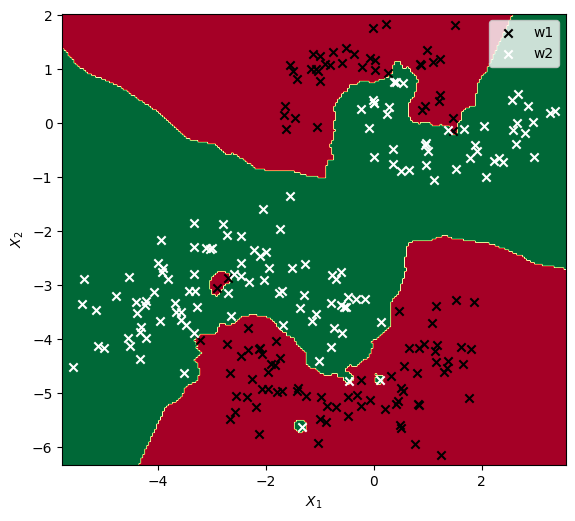

In [ ]:
'''
1. commented source code
2. classification map with training samples plotted
'''
# Fit the model with the parameters of the best performance
bestmodelkNN = modelkNN = KNeighborsClassifier(n_neighbors=5, weights='distance', metric ='euclidean')
bestmodelkNN.fit(X_train,y_train)

#PLOT CLASSIFICATION MAP
plt.figure(figsize=(6.5, 6.5))
plot_classification_map(X_train,y_train,bestmodelkNN,plt)

d)	Report on the classifier performance using the test dataset:

•	measure the test accuracy, test precision, test recall and test f1-score, and

•	in a single figure, plot the test samples over the already calculated classification map (use different markers and/or colours for each class).


Accuracy= 0.95
Precision= 0.885
Recall= 1.0
F_1 Score 0.939


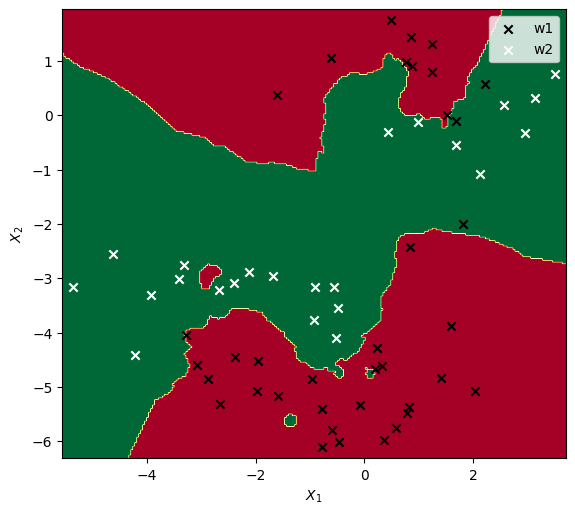

In [ ]:
'''
1. commented source code
2. test accuracy, test precision, test recall and test f1-score
3. classification map with test samples plotted
'''
#Predict the test samples
predictions = bestmodelkNN.predict(X_test)

print(f'Accuracy= {accuracy_score(y_test, predictions).round(3)}')
print(f'Precision= {precision_score(y_test, predictions).round(3)}')
print(f'Recall= {recall_score(y_test, predictions).round(3)}')
print(f'F_1 Score {f1_score(y_test, predictions).round(3)}')

#PLOT CLASSIFICATION MAP
plt.figure(figsize=(6.5, 6.5))
plot_classification_map(X_test,y_test,bestmodelkNN,plt)

e)	Obtain an improved estimation of the accuracy, precision, recall and f1-score measures by means of repeated, n-fold cross-validation. To this end, put together the training and test datasets, so that the corresponding function can build the folds from all available data.

In [ ]:
'''
1. commented source code
2. accuracy, precision, recall and f1-score
'''
#Merged teste and train samples
all_Xdata =np.vstack((X_train, X_test))
all_ydata = np.concatenate((y_train,y_test))

modelkNN_e = modelkNN = KNeighborsClassifier(n_neighbors=5, weights='distance', metric ='euclidean')

accuracy_e, precision_e, recall_e, f1_score_e = calculateModel_crossValidation(all_Xdata,all_ydata,modelkNN_e)
print(f'Accuracy= {accuracy_e.round(3)}')
print(f'Precision= {precision_e.round(3)}')
print(f'Recall= {recall_e.round(3)}')
print(f'F_1 Score {f1_score_e.round(3)}')

Accuracy= 0.949
Precision= 0.957
Recall= 0.942
F_1 Score 0.949
